In [21]:
import os
import json
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
import re
import requests

In [44]:
def load_api_key(path: str = "../keys.json") -> None:
    """Load OpenAI API key from a JSON file into environment."""
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    os.environ["OPENAI_API_KEY"] = data.get("openai_api_key")


def evaluate_two_mindmaps(ground_truth_path: str, prediction_path: str) -> dict:
    """Evaluate a single pair of ground-truth vs generated mind maps using GPT-4o-mini.

    Returns a dict of scores and comments for Visual, Cognitive, Functional, Structural, and overall."""
    # Read files
    with open(ground_truth_path, 'r', encoding='utf-8') as f:
        ground_truth = f.read().strip()
    with open(prediction_path, 'r', encoding='utf-8') as f:
        prediction = f.read().strip()

    prompt = f"""
You are an expert evaluator. Compare two mind maps based on the following dimensions:

1. **Cognitive Indicators**: How easily can a user understand and mentally process the information?  
   Consider clarity, flow of ideas, and thematic relevance.

2. **Structural Indicators**: How well-organized and logically complete is the mind map?  
   Consider grouping of ideas, coverage of key concepts, level of detail, and consistent hierarchy.

Scoring Instructions (Use a 1–7 Likert scale):
- Use **4** if the generated mind map is about equal in quality to the ground truth.
- Use **5–7** if the generated mind map is better than the ground truth (7 = much better).
- Use **3–1** if the generated mind map is worse than the ground truth (1 = much worse).

Return your evaluation in the following JSON format (no extra text):

{{
  "cognitive_score": int,
  "cognitive_comment": "string",
  "structural_score": int,
  "structural_comment": "string"
}}

Ground Truth Mind Map:
{ground_truth}

Generated Mind Map:
{prediction}
"""
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("OPENAI_API_KEY not set — run load_api_key() first.")

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "gpt-4o-mini",
        "messages": [
            {"role": "system", "content": "You are a strict evaluator of mind maps."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response.raise_for_status()

    text = response.json()["choices"][0]["message"]["content"].strip()
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        match = re.search(r"\{.*\}", text, re.S)
        if match:
            return json.loads(match.group())
        raise




In [45]:
load_api_key()

# Replace these with your two file paths
ground_truth_file = "../data/tqa_train_val_test/test/mindmap_text/mermaid_code_L_0001.txt"
prediction_file = "../data/tqa_train_val_test/test/test_predictions/prediction_L_0001.txt"

result = evaluate_two_mindmaps(ground_truth_file, prediction_file)
print(json.dumps(result, indent=2))

{
  "cognitive_score": 4,
  "cognitive_comment": "The generated mind map presents the information in a clear manner, but the flow of ideas is less intuitive compared to the ground truth. Some thematic relevance is maintained, but the organization of concepts could be improved for better understanding.",
  "structural_score": 3,
  "structural_comment": "The generated mind map lacks a consistent hierarchy and does not cover all key concepts as thoroughly as the ground truth. Some ideas are grouped together in a way that may confuse users, and the level of detail varies significantly across sections."
}


In [46]:
load_api_key()

# Replace these with your two file paths
ground_truth_file = "../data/tqa_train_val_test/test/mindmap_text/mermaid_code_L_0001.txt"
prediction_file = "../data/gen_mindmap/mindmap_L0001.txt"

result = evaluate_two_mindmaps(ground_truth_file, prediction_file)
print(json.dumps(result, indent=2))

{
  "cognitive_score": 5,
  "cognitive_comment": "The generated mind map presents information in a clear and organized manner, making it easy for users to understand the relationships between concepts. However, some thematic relevance is slightly less direct compared to the ground truth, which may affect immediate comprehension.",
  "structural_score": 6,
  "structural_comment": "The generated mind map is well-organized and covers key concepts effectively, with a logical hierarchy. It provides a good level of detail and groups ideas appropriately, although some areas could benefit from more explicit connections to enhance completeness."
}


In [47]:


def evaluate_folder_and_save(ground_truth_folder: str, prediction_folder: str, output_file: str) -> None:
    """
    Evaluate all mind map pairs in the given folders and store the results in a JSON file.

    Ground truth files are expected to be named like:
      mermaid_code_L_0001.txt

    The corresponding prediction file should be named:
      prediction_L_0001.txt
    """
    evaluations = {}
    # Iterate over files in the ground truth folder.
    for filename in os.listdir(ground_truth_folder):
        # Check that the file follows the naming pattern.
        if not filename.startswith("mermaid_code_"):
            continue

        gt_path = os.path.join(ground_truth_folder, filename)
        # Replace the prefix to create the prediction file name.
        pred_filename = filename.replace("mermaid_code_", "prediction_")
        pred_path = os.path.join(prediction_folder, pred_filename)
        
        if os.path.isfile(gt_path) and os.path.isfile(pred_path):
            try:
                result = evaluate_two_mindmaps(gt_path, pred_path)
                evaluations[filename] = result
                print(f"Evaluated: {filename} and {pred_filename}")
            except Exception as e:
                print(f"Error evaluating {filename}: {e}")
        else:
            print(f"Skipping {filename}: corresponding prediction file {pred_filename} not found.")

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(evaluations, f, indent=2)
    print(f"Saved evaluations to {output_file}")



In [62]:
def analyze_results(evaluations_file: str, ground_truth_folder: str, prediction_folder: str) -> None:
    """
    Load evaluations from the JSON file, compute average and standard deviation of scores,
    plot histograms and line plots, and print the best and worst mind map predictions
    (with their comments and full texts) for each category.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import json
    import statistics

    with open(evaluations_file, 'r', encoding='utf-8') as f:
        evaluations = json.load(f)

    if not evaluations:
        print("No evaluations found in file.")
        return

    score_keys = ["cognitive_score", "structural_score"]

    # Collect scores
    scores = {key: [] for key in score_keys}
    for fname, result in evaluations.items():
        for key in score_keys:
            try:
                scores[key].append((fname, float(result.get(key, 0))))
            except Exception as e:
                print(f"Error processing score for {fname} in {key}: {e}")

    # Compute average and standard deviation
    score_stats = {}
    for key in score_keys:
        values = [score for _, score in scores[key]]
        if values:
            score_stats[key] = {
                "mean": sum(values) / len(values),
                "std": statistics.stdev(values) if len(values) > 1 else 0.0
            }
        else:
            score_stats[key] = {"mean": 0.0, "std": 0.0}

    print("Score Summary:")
    print(json.dumps(score_stats, indent=2))

    # Plotting
    for key in score_keys:
        values = sorted(scores[key], key=lambda x: x[1])
        score_values = [score for _, score in values]

        # Line plot
        plt.figure(figsize=(12, 4))
        plt.plot(score_values, marker='o')
        plt.title(f"Line Plot of {key}")
        plt.xlabel("Sample (sorted by score)")
        plt.ylabel("Score")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Histogram
        plt.figure(figsize=(8, 4))
        sns.histplot(score_values, bins=[0.5 + i for i in range(8)], discrete=True)
        plt.xticks(range(1, 8))
        plt.title(f"Distribution of {key} scores")
        plt.xlabel("Score (Likert scale)")
        plt.ylabel("Frequency")
        plt.grid(axis="y")
        plt.tight_layout()
        plt.show()

    # Print best/worst samples
    for key in score_keys:
        if not scores[key]:
            continue
        worst = min(scores[key], key=lambda x: x[1])
        best = max(scores[key], key=lambda x: x[1])
        comment_key = key.replace("_score", "_comment")

        for label, fname in [("Worst", worst[0]), ("Best", best[0])]:
            score = dict(scores[key])[fname]
            comment = evaluations[fname].get(comment_key, '')
            print(f"\nCategory: {key} - {label}: {fname} with score {score}")
            print(f"Comment: {comment}")

            gt_file = os.path.join(ground_truth_folder, fname)
            pred_file = os.path.join(prediction_folder, fname.replace("mermaid_code_", "prediction_"))

            try:
                with open(gt_file, 'r', encoding='utf-8') as f:
                    gt_content = f.read().strip()
                with open(pred_file, 'r', encoding='utf-8') as f:
                    pred_content = f.read().strip()

                print("Ground Truth:")
                print(gt_content)
                print("\nPrediction:")
                print(pred_content)
            except Exception as e:
                print(f"Error loading files for {fname}: {e}")


In [49]:

load_api_key()

# Set your folder paths (adjust as needed)
ground_truth_folder = "../data/tqa_train_val_test/test/mindmap_text"
prediction_folder = "../data/tqa_train_val_test/test/test_predictions"
output_file = "../data/tqa_train_val_test/test/llm_judge_evaluation_results.json"



In [50]:
# Step 1: Evaluate all mind map pairs and save the individual JSON outputs.
evaluate_folder_and_save(ground_truth_folder, prediction_folder, output_file)


Evaluated: mermaid_code_L_0565.txt and prediction_L_0565.txt
Evaluated: mermaid_code_L_0672.txt and prediction_L_0672.txt
Evaluated: mermaid_code_L_0497.txt and prediction_L_0497.txt
Evaluated: mermaid_code_L_0027.txt and prediction_L_0027.txt
Evaluated: mermaid_code_L_0446.txt and prediction_L_0446.txt
Evaluated: mermaid_code_L_0562.txt and prediction_L_0562.txt
Evaluated: mermaid_code_L_0029.txt and prediction_L_0029.txt
Evaluated: mermaid_code_L_0448.txt and prediction_L_0448.txt
Evaluated: mermaid_code_L_0339.txt and prediction_L_0339.txt
Evaluated: mermaid_code_L_0600.txt and prediction_L_0600.txt
Evaluated: mermaid_code_L_0711.txt and prediction_L_0711.txt
Evaluated: mermaid_code_L_1075.txt and prediction_L_1075.txt
Evaluated: mermaid_code_L_0254.txt and prediction_L_0254.txt
Evaluated: mermaid_code_L_0195.txt and prediction_L_0195.txt
Evaluated: mermaid_code_L_0632.txt and prediction_L_0632.txt
Evaluated: mermaid_code_L_0377.txt and prediction_L_0377.txt
Evaluated: mermaid_code_

Score Summary:
{
  "cognitive_score": {
    "mean": 4.4523809523809526,
    "std": 0.6563047544669555
  },
  "structural_score": {
    "mean": 3.723809523809524,
    "std": 0.9123841012612078
  }
}


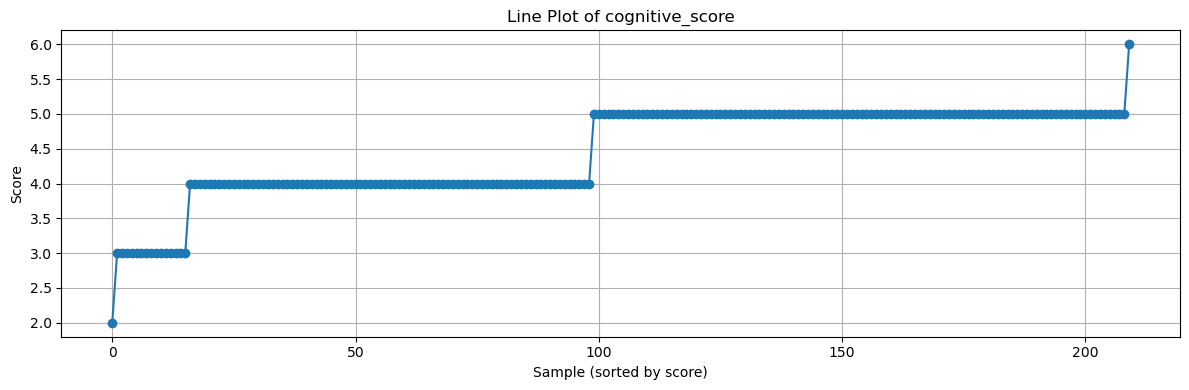

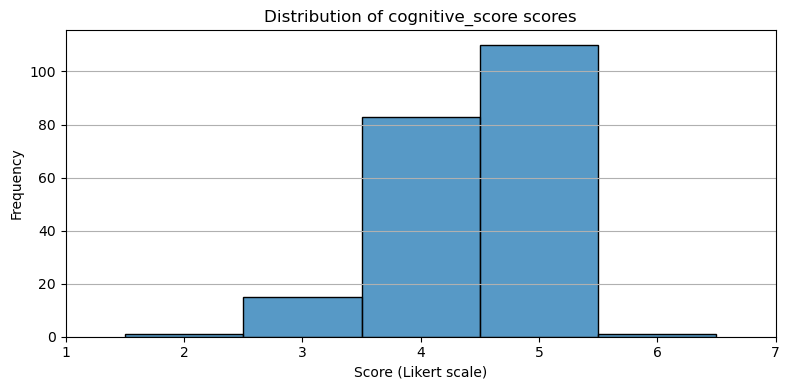

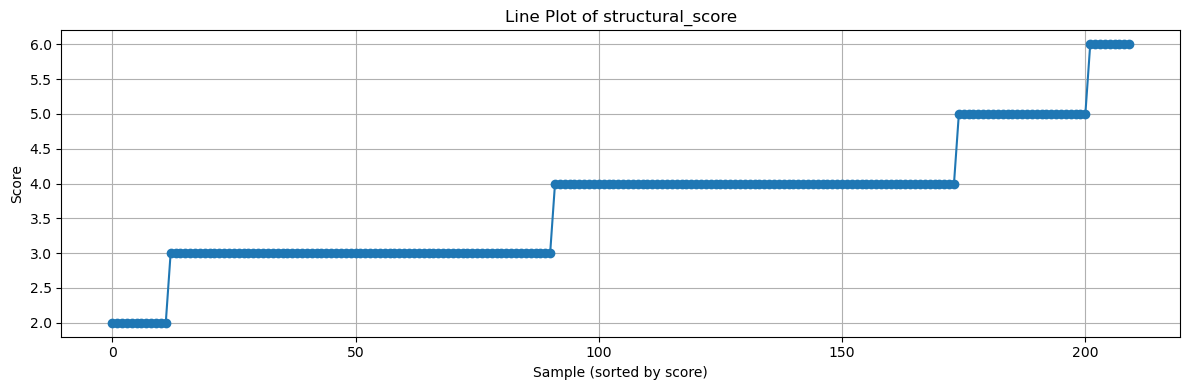

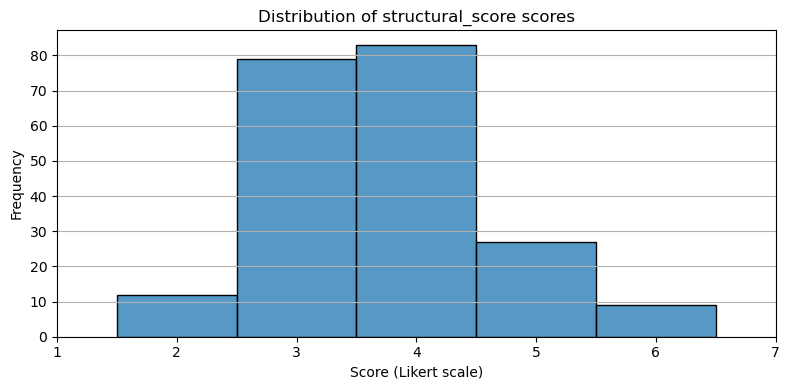


Category: cognitive_score - Worst: mermaid_code_L_0462.txt with score 2.0
Comment: The generated mind map lacks clarity and thematic relevance, making it difficult for users to understand and mentally process the information. The flow of ideas is convoluted and does not effectively convey the main concepts related to biotechnology in agriculture.
Ground Truth:
mindmap
  Biotechnology in Agriculture
    Food Chains
      Definition
        Diagram of feeding interactions
        Single pathway
      Characteristics
        Begins with producers
        Limited levels (3-5)
      Example
        Plant -> Grasshopper -> Bird -> Snake -> Owl
    Food Webs
      Definition
        Diagram of feeding interactions
        Multiple intersecting pathways
      Characteristics
        Shows many organisms
        Complex feeding relationships
      Example
        Phytoplankton -> Krill -> Fish -> Shark
    Energy Flow
      Importance
        Constant flow for ecosystem stability
      Mechani

In [63]:
import matplotlib.pyplot as plt
# Step 2: Later, load the saved JSON file, compute average metrics, and plot histograms.
analyze_results(output_file,ground_truth_folder, prediction_folder)